In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from spot_gl.spot_basic import *
from spot_gl.spot_arm import *
from spot_gl.spot_graph_nav import *
from spot_gl.gl_functions import *

In [3]:
#### CONSTANTS ####
all_wp_move_look = [(10, [0, 0, np.pi/4], [2, 0, 2.5]),
                    (18, [0, -0.7, np.pi/2], [1, 0, 4.0]),
                    (22, [0, 0, np.pi/3], [3, 0, 3.0]),
                    (0 , [0, 0, np.pi/4], [3, 0 ,3.0])]

switch_coords_fid_580_frame = [[-0.3, 0.25, 0.10],
                                    [-0.3, 0.36, 0.10]]

In [42]:
move_robot_relative(command_client, robot, 0, -0.3, 0)

In [4]:
sdk, robot, id_client, \
robot_state_client, command_client, \
image_client, graph_nav_client, \
world_object_client, manipulation_api_client = init_robot('192.168.50.3')

In [6]:
lease_client, lease, lease_keep_alive = get_lease(robot)

In [31]:
gl = Groundlight(api_token=os.environ.get("GROUNDLIGHT_API_TOKEN"))
det_list = gl.list_detectors(page_size = 20)
det_names = [det.name for det in det_list.results]

switch_det_name = 'switchUp'
light_det_name = 'lightOn'

switch_det = det_list.results[det_names.index(switch_det_name)]
light_det = det_list.results[det_names.index(light_det_name)]


In [35]:
get_batt_info(robot_state_client)

Battery at: 79.0 %. Robot has 4488 seconds left


(79.0, 4488)

In [36]:
success = power_on(robot)

In [37]:
bdcrc.blocking_selfright(command_client, timeout_sec = 20)

In [38]:
bdcrc.blocking_stand(command_client, timeout_sec = 20)

In [40]:
response = upload_graph_and_snapshots(graph_nav_client, graph_upload_filepath)
success = graph_localize_fiducial(command_client, graph_nav_client, robot_state_client, robot)
waypoint_list = create_waypoint_list(graph_nav_client)

In [58]:
def rand_imgs_thru_det(command_client, image_client, gl, det, look_at, num_images = 4):
    for i in range(num_images):
        move_to = [np.random.uniform(0.3,1),
               np.random.uniform(-0.1,0.1),
               np.random.uniform(0.4,0.8)]

        blocking_stow(command_client)

        move_to_and_look_at(command_client, move_to, look_at)
        
        time.sleep(0.5)
        
        hand_color_image, _ = cap_hand_image(image_client, "hand_color_image")
        
        image_query = mat_thru_det(gl, det, hand_color_image)

In [14]:
def get_fid_info(world_object_client, fid_num):
    request_fiducials = [world_object_pb2.WORLD_OBJECT_APRILTAG]
    fiducial_objects = world_object_client.list_world_objects(
                object_type=request_fiducials).world_objects
    time.sleep(0.5)

    fid = None
    for fiducial_obj in fiducial_objects:
        if fiducial_obj.apriltag_properties.tag_id == fid_num:
            fid = fiducial_obj
    if fid is None:
        logging.error("COULD NOT FIND FIDUCIAL {}".format(fid_num))
    fid_tree_snapshot = fid.transforms_snapshot
    vision_tform_fid = get_a_tform_b(fid_tree_snapshot, 
                                         frame_a = 'vision', 
                                         frame_b ='filtered_fiducial_{}'.format(fid_num))
    fid_loc = {'fid_tree_snapshot': fid_tree_snapshot,
               'vision_tform_fid': vision_tform_fid}
    
    return fid_loc

In [15]:
def robot_go_to_in_fid_frame(command_client, vision_tform_fid, x, y, z):
    robot_rot = np.array([0,1,0])

    robot_rot_obj = sciRot.from_euler('xyz',np.pi/2*robot_rot)
    robot_rot_mtx = robot_rot_obj.as_matrix()
    robot_rot_quat = bdcmh.Quat.from_matrix(robot_rot_mtx)

    robot_pose_fid_frame_proto = geometry_pb2.SE3Pose(
        position = geometry_pb2.Vec3(x = x, y = y, z = z),
        rotation = robot_rot_quat.to_proto()
    )

    robot_pose_fid_frame_se3 = bdcmh.SE3Pose.from_proto(robot_pose_fid_frame_proto)

    robot_pose_vision_frame_se3 = (vision_tform_fid * robot_pose_fid_frame_se3)

    flat_robot_pose_vision_frame_se2 = bdcmh.SE2Pose.flatten(robot_pose_vision_frame_se3)
    flat_robot_pose_vision_frame_se2.to_proto()

    cmd = RobotCommandBuilder.synchro_se2_trajectory_command(
        goal_se2 = flat_robot_pose_vision_frame_se2.to_proto(), 
        frame_name = 'vision'
    )

    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    bdcrc.block_for_trajectory_cmd(command_client, cmd_id, timeout_sec = timeout_sec)

In [1]:
def hand_go_to_in_fid_frame(command_client, vision_tform_fid, x, y, z, blocking = True, follow = False):
    hand_rot = np.array([0,1,0])
    rotObj = sciRot.from_euler('xyz',np.pi/2*hand_rot)
    rot_mtx = rotObj.as_matrix()
    rot_quat = bdcmh.Quat.from_matrix(rot_mtx)

    hand_pose_fid_frame_proto = geometry_pb2.SE3Pose(
        position = geometry_pb2.Vec3(x = x, y = y, z = z), 
        rotation = rot_quat.to_proto())

    hand_pose_fid_frame_se3 = bdcmh.SE3Pose.from_proto(hand_pose_fid_frame_proto)

    hand_pose_vision_frame_se3 = (vision_tform_fid * hand_pose_fid_frame_se3)
    
    body_cmd = RobotCommandBuilder.follow_arm_command()
    cmd = RobotCommandBuilder.arm_pose_command(x = hand_pose_vision_frame_se3.x,
                                               y = hand_pose_vision_frame_se3.y,
                                               z = hand_pose_vision_frame_se3.z,
                                               qw = hand_pose_vision_frame_se3.rotation.w,
                                               qx = hand_pose_vision_frame_se3.rotation.x,
                                               qy = hand_pose_vision_frame_se3.rotation.y,
                                               qz = hand_pose_vision_frame_se3.rotation.z,
                                               frame_name = 'vision')
    if follow:
        cmd = RobotCommandBuilder.build_synchro_command(body_cmd, cmd)

    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    
    if blocking:
        bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = timeout_sec)

NameError: name 'np' is not defined

In [43]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[0], cmd_duration = 15)
wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)

In [17]:
# nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[20], cmd_duration = 15)
# wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)
# move_robot_relative(command_client, robot, 1, 1, 0)

# body_orientation = bosdyn.geometry.EulerZXY(yaw = 0, roll = 0, pitch = -np.pi/4)
# cmd = RobotCommandBuilder.synchro_stand_command(body_height = 0.15,
#                                                 footprint_R_body = body_orientation)
# cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
# time.sleep(3)

# fid_loc = get_fid_info(world_object_client, fid_num = 580)
# fid_tree_snapshot = fid_loc['fid_tree_snapshot']
# vision_tform_fid = fid_loc['vision_tform_fid']
# prev_graph_state = graph_del_save_state(graph_nav_client, robot)

# gripper_open(command_client)

# bdcrc.blocking_stand(command_client, timeout_sec = 20)
# for x,y,z in switch_image_coords_fid_580_frame:
#     print(x, y, z)
#     move_to_and_look_at(command_client, [0.5,0,0.8], [3,0,0.8])
#     robot_go_to_in_fid_frame(command_client, vision_tform_fid, x = -0.5, y = y, z = 1.2)
#     hand_go_to_in_fid_frame(command_client, vision_tform_fid, x, y, z)
#     time.sleep(5)
#     hand_color_image, image_response = cap_hand_image(image_client, 'hand_color_image')
#     move_robot_relative(command_client, robot, -0.3, 0, 0)
#     blocking_stow(command_client)
# #    image_query = mat_thru_det(gl, switch_det, hand_color_image)
#     plt.imshow(hand_color_image)
#     plt.show()

In [18]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.3)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [52]:
def get_switch_fid_frame(command_client, world_object_client):
    blocking_stow(command_client)
    bdcrc.blocking_stand(command_client, timeout_sec = 20)

    body_orientation = bosdyn.geometry.EulerZXY(yaw = 0, roll = 0, pitch = -np.pi/4)
    cmd = RobotCommandBuilder.synchro_stand_command(body_height = 0.15,
                                                    footprint_R_body = body_orientation)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    time.sleep(3)

    fid_loc = get_fid_info(world_object_client, fid_num = 580)

    bdcrc.blocking_stand(command_client, timeout_sec = 20)
    
    return fid_loc

In [53]:
def flick_switch(*, command_client, 
                 world_object_client,
                 image_client,
                 gl,
                 switch_det,
                 switch_num, 
                 flick_up):
    
    fid_loc = get_switch_fid_frame(command_client, world_object_client)
    fid_tree_snapshot = fid_loc['fid_tree_snapshot']
    vision_tform_fid = fid_loc['vision_tform_fid']

    move_to_and_look_at(command_client, [0.4,0,0.8], [3,0,0.8])

    #for x,y,z in switch_coords_fid_580_frame:
    
    vertical_start = 0.045
    vertical_end = -0.045
    
    if flick_up:
        vertical_start *= -1
        vertical_end *= -1
        
    x, y, z = switch_coords_fid_580_frame[switch_num]
    
    #MOVE ROBOT INTO POSITION
    robot_go_to_in_fid_frame(command_client, vision_tform_fid, x = -0.5, y = y, z = 0.7)
    
    gripper_open(command_client)
    #MOVE HAND INTO POSITION TO CAP IMAGE
    hand_go_to_in_fid_frame(command_client, vision_tform_fid, x, y, z + 0.05)
    
    hand_color_image, _ = cap_hand_image(image_client, "hand_color_image")
    image_query = mat_thru_det(gl, switch_det, hand_color_image)
    time.sleep(0.3)
    
    #BACK UP HAND
    hand_go_to_in_fid_frame(command_client, vision_tform_fid, x, y, z + 0.15)
    
    # FLICK
    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.3)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    
    hand_go_to_in_fid_frame(command_client, vision_tform_fid, 
                            x+vertical_start, y, z,
                            blocking = True)
    
    hand_go_to_in_fid_frame(command_client, vision_tform_fid, 
                            x+vertical_end, y, z,
                            blocking = True)

    #BACK UP HAND
    hand_go_to_in_fid_frame(command_client, vision_tform_fid, 
                            x+vertical_end, y, z+0.3,
                            blocking = True)

    blocking_stow(command_client)
    move_robot_relative(command_client, robot, -0.5, 0, 0)

In [54]:
def toggle_lights(command_client, 
                  world_object_client,
                  image_client,
                  graph_nav_client,
                  switch_up = True):
    
    nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[20], cmd_duration = 15)
    wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)
    move_robot_relative(command_client, robot, 1, 1, 0)
    
    prev_graph_state = graph_del_save_state(graph_nav_client, robot)
    
    for switch_num in range(2):
        flick_switch(command_client = command_client,
            world_object_client = world_object_client,
            image_client = image_client,
            gl = gl,
            switch_det = switch_det,
            switch_num = switch_num,
            flick_up = not switch_up)
        
    response = upload_graph_and_snapshots(graph_nav_client, graph_upload_filepath)
    response = graph_localize_saved_state(graph_nav_client, robot, prev_graph_state)

In [ ]:
toggle_

In [59]:
switch_up = True

for i in range(3):
    for wp, move, look_at in all_wp_move_look:
        print(wp, move, look_at)
        nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[wp], cmd_duration = 15)
        wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)
        move_robot_relative(command_client, robot, move[0], move[1], move[2])

        prev_graph_state = graph_del_save_state(graph_nav_client, robot)

        gripper_open(command_client)
        rand_imgs_thru_det(command_client, image_client, gl, light_det, look_at)
        blocking_stow(command_client)

        response = upload_graph_and_snapshots(graph_nav_client, graph_upload_filepath)
        response = graph_localize_saved_state(graph_nav_client, robot, prev_graph_state)

    toggle_lights(command_client, 
                  world_object_client, 
                  image_client,
                  graph_nav_client, 
                  switch_up = switch_up)

    switch_up = not switch_up

10 [0, 0, 0.7853981633974483] [2, 0, 2.5]


18 [0, -0.7, 1.5707963267948966] [1, 0, 5.0]


22 [0, 0, 1.0471975511965976] [2, 0, 4.0]


0 [0, 0, 0.7853981633974483] [3, 0, 3.0]


10 [0, 0, 0.7853981633974483] [2, 0, 2.5]


18 [0, -0.7, 1.5707963267948966] [1, 0, 5.0]


22 [0, 0, 1.0471975511965976] [2, 0, 4.0]


0 [0, 0, 0.7853981633974483] [3, 0, 3.0]


ERROR:root:COULD NOT FIND FIDUCIAL 580


AttributeError: 'NoneType' object has no attribute 'transforms_snapshot'

In [40]:
for i in range(1):
    for flick_up in range(2):
        for switch_num in range(2):
            flick_switch(command_client = command_client,
                world_object_client = world_object_client,
                image_client = image_client,
                gl = gl,
                switch_det = switch_det,
                switch_num = switch_num,
                flick_up = flick_up)

In [57]:
move_to_and_look_at(command_client, [0.4,0,0.8], [3,0,0.8])
hand_go_to_in_fid_frame(command_client, vision_tform_fid, x, y, z)

In [70]:
move_robot_relative(command_client, robot, -0.5, 0, 0)

In [34]:
move_to_and_look_at(command_client, [1.2,0,0.7], [3,0,0.7])

In [34]:
response = upload_graph_and_snapshots(graph_nav_client, graph_upload_filepath)
response = graph_localize_saved_state(graph_nav_client, robot, prev_graph_state)

In [39]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[20], cmd_duration = 15)
wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)

In [81]:
# vision_tform_body = get_vision_tform_body(fid_tree_snapshot)

In [83]:
blocking_stow(command_client)

True

In [85]:
gripper_open(command_client)

In [104]:
body_cmd = RobotCommandBuilder.follow_arm_command()
arm_cmd = RobotCommandBuilder.arm_pose_command(x = hand_pose_vision_frame_se3.x,
                                           y = hand_pose_vision_frame_se3.y,
                                           z = hand_pose_vision_frame_se3.z,
                                           qw = hand_pose_vision_frame_se3.rotation.w,
                                           qx = hand_pose_vision_frame_se3.rotation.x,
                                           qy = hand_pose_vision_frame_se3.rotation.y,
                                           qz = hand_pose_vision_frame_se3.rotation.z,
                                           frame_name = 'vision')
cmd = RobotCommandBuilder.build_synchro_command(body_cmd, arm_cmd)

cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [101]:
prev_graph_state = graph_del_save_state(graph_nav_client, robot)

In [105]:
hand_color_image, image_response = cap_hand_image(image_client, 'hand_color_image')

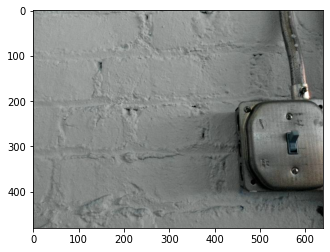

In [106]:
plt.imshow(hand_color_image)

In [107]:
move_robot_relative(command_client, robot, -0.5, 0, 0)

In [108]:
blocking_stow(command_client)

True

In [145]:
prev_graph_state['vision_tform_waypoint_se3'].to_proto()

position {
  x: -0.5320955218097831
  y: -0.6376975100636452
  z: 0.36408161514475945
}
rotation {
  x: 0.028650492429733276
  y: 0.0011518108658492565
  z: 0.99735027551651
  w: 0.06686027348041534
}

In [146]:
response = upload_graph_and_snapshots(graph_nav_client, graph_upload_filepath)
response = graph_localize_saved_state(graph_nav_client, robot, prev_graph_state)

InvalidRequestError: bosdyn.api.graph_nav.SetLocalizationResponse (InvalidRequestError): to_waypoint not set?

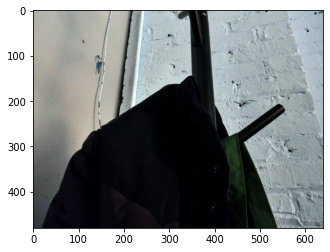

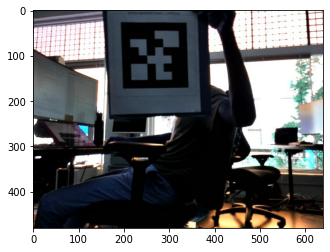

In [67]:
plt.imshow(hand_color_image)

In [15]:
# [2,0,2.5] for 10

# [1,0,5] for 18

# [2, 0, 4] for 22

# [3, 0, 3] for 0




In [11]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[8], cmd_duration = 15)
wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)
#move_robot_relative(command_client, robot, 0, 0, np.pi/4)

NameError: name 'waypoint_list' is not defined

In [56]:
move_to_and_look_at(command_client, [0.8,0,0.5], [3, 0, 3])

In [72]:
move_robot_relative(command_client, robot, 0, -2, 0)

In [ ]:
wp_ind_list = [0, 8, 10, 12, 15]
for wp_ind in wp_ind_list:
    blocking_stow(command_client)
    nav_to_cmd_id = graph_nav_client.navigate_to(waypoint_list[wp_ind], cmd_duration = 15)
    wait_until_finished_nav(graph_nav_client, nav_to_cmd_id)
    prev_graph_state = graph_del_save_state(graph_nav_client, robot)
    gripper_open(command_client)
    rand_imgs_thru_det(command_client, image_client, gl, rubiks_det)
    gripper_close(command_client)
    upload_graph_and_snapshots(graph_nav_client, graph_upload_filepath)
    response = graph_localize_saved_state(graph_nav_client, robot, prev_graph_state)